In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pytz


# Display full lenght of data in cells
pd.set_option('display.max_colwidth', None)

# Display full length of number of displayed columns
pd.set_option('display.max_columns', None)

# Display floats with 2 decimals
pd.set_option('display.float_format', '{:20,.2f}'.format)

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Hamoye')
!pwd

/content/drive/MyDrive/Colab Notebooks/Hamoye


In [4]:
!ls

Time_series_analysis_and_forecast_DATASET.csv


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Hamoye/'

In [6]:
df = pd.read_csv(path+"Time_series_analysis_and_forecast_DATASET.csv")

print("Shape:", df.shape)
print(df.info())
df.head()

Shape: (92016, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FullDate   92016 non-null  object 
 1   Tmax       92016 non-null  float64
 2   SysLoad    92016 non-null  float64
 3   GasPrice   92016 non-null  float64
 4   ElecPrice  92016 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.5+ MB
None


,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.80,"1,688.21",3.69,23.71
1,2010-09-01 01:00:00,15.80,"1,669.20",3.69,22.64
2,2010-09-01 02:00:00,15.80,"1,491.98",3.69,22.57
3,2010-09-01 03:00:00,15.80,"1,330.76",3.69,18.91
4,2010-09-01 04:00:00,15.80,"1,247.94",3.69,18.03


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.columns

Index(['fulldate', 'tmax', 'sysload', 'gasprice', 'elecprice'], dtype='object')

In [9]:
#Convert full date from object datatype to datetime

df.fulldate= pd.to_datetime(df.fulldate)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fulldate   92016 non-null  datetime64[ns]
 1   tmax       92016 non-null  float64       
 2   sysload    92016 non-null  float64       
 3   gasprice   92016 non-null  float64       
 4   elecprice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB
None


In [10]:
#Downsample to daily data points because the data is on hourly basis

#Set full date to index
df.set_index("fulldate", inplace= True )
df.head() 

,tmax,sysload,gasprice,elecprice
fulldate,,,,
2010-09-01 00:00:00,15.80,"1,688.21",3.69,23.71
2010-09-01 01:00:00,15.80,"1,669.20",3.69,22.64
2010-09-01 02:00:00,15.80,"1,491.98",3.69,22.57
2010-09-01 03:00:00,15.80,"1,330.76",3.69,18.91
2010-09-01 04:00:00,15.80,"1,247.94",3.69,18.03


In [11]:
# Downsample to daily data points because the data is on hourly basis

df_daily = df.resample("D").mean()
print("Shape Before Resampling:", df.shape) 
print("Shape After Resampling:", df_daily.shape)
df_daily.head()

Shape Before Resampling: (92016, 4)
Shape After Resampling: (3834, 4)


,tmax,sysload,gasprice,elecprice
fulldate,,,,
2010-09-01,15.80,"1,731.89",3.69,114.65
2010-09-02,15.40,"1,620.79",3.69,23.78
2010-09-03,18.30,"1,736.07",4.45,21.04
2010-09-04,13.70,"1,484.92",3.39,20.93
2010-09-05,14.90,"1,483.81",4.45,20.86


In [12]:
#Reset the index to make full date a column again

df_daily.reset_index(inplace=True)

In [13]:
df_daily.head()

,fulldate,tmax,sysload,gasprice,elecprice
0,2010-09-01,15.80,"1,731.89",3.69,114.65
1,2010-09-02,15.40,"1,620.79",3.69,23.78
2,2010-09-03,18.30,"1,736.07",4.45,21.04
3,2010-09-04,13.70,"1,484.92",3.39,20.93
4,2010-09-05,14.90,"1,483.81",4.45,20.86


In [14]:
df_daily = df_daily.rename(columns={"fulldate" : "ds" , "elecprice" : "y"})
print(df_daily.shape)
print(df_daily.info())
df_daily.head()

(3834, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        3834 non-null   datetime64[ns]
 1   tmax      3834 non-null   float64       
 2   sysload   3834 non-null   float64       
 3   gasprice  3834 non-null   float64       
 4   y         3834 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 149.9 KB
None


,ds,tmax,sysload,gasprice,y
0,2010-09-01,15.80,"1,731.89",3.69,114.65
1,2010-09-02,15.40,"1,620.79",3.69,23.78
2,2010-09-03,18.30,"1,736.07",4.45,21.04
3,2010-09-04,13.70,"1,484.92",3.39,20.93
4,2010-09-05,14.90,"1,483.81",4.45,20.86


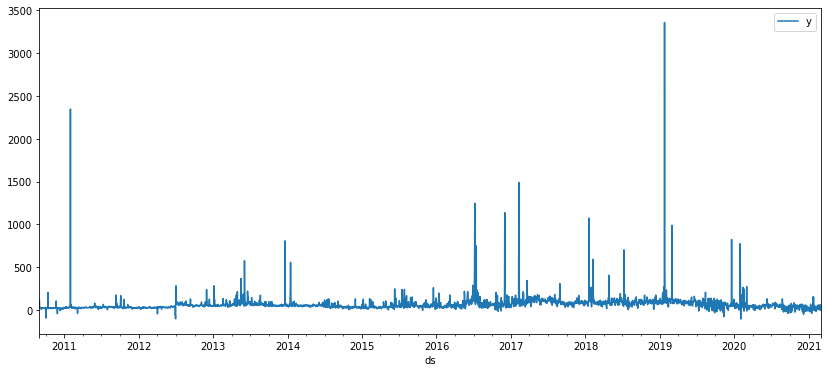

In [15]:
#Visualize the data

# plot the time series
fig, ax = plt.subplots(figsize=(14,6))
df_daily.plot(x="ds", y='y', ax=ax);

In [16]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        3834 non-null   datetime64[ns]
 1   tmax      3834 non-null   float64       
 2   sysload   3834 non-null   float64       
 3   gasprice  3834 non-null   float64       
 4   y         3834 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 149.9 KB


In [17]:
#Split the data with df_daily

train = df_daily.iloc[:2757]
test = df_daily.iloc[2757:]

print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (2757, 5)
test shape: (1077, 5)


In [18]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2010-09-01 00:00:00
The end time of the training dataset is  2018-03-19 00:00:00
The start time of the testing dataset is  2018-03-20 00:00:00
The end time of the testing dataset is  2021-02-28 00:00:00


## Univariate Time series model.

**- I discovered that you don't necessarily have to create a new DataFrame to pull out the ds and y columns as once it's present as a named column in the data, prophet automatically selects them.**

In [19]:
#model building df_daily

model_univariate = Prophet()
model_univariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/o35f50xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/znfl3y0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35622', 'data', 'file=/tmp/tmpr6qgeliq/o35f50xg.json', 'init=/tmp/tmpr6qgeliq/znfl3y0z.json', 'output', 'file=/tmp/tmpr6qgeliq/prophet_modelp07my4a0/prophet_model-20230122145635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
#make test data as the future into a dataframe

future_univariate = pd.DataFrame(test['ds'])

# future = model_univariate.make_future_dataframe(periods=len(test), freq='1D')

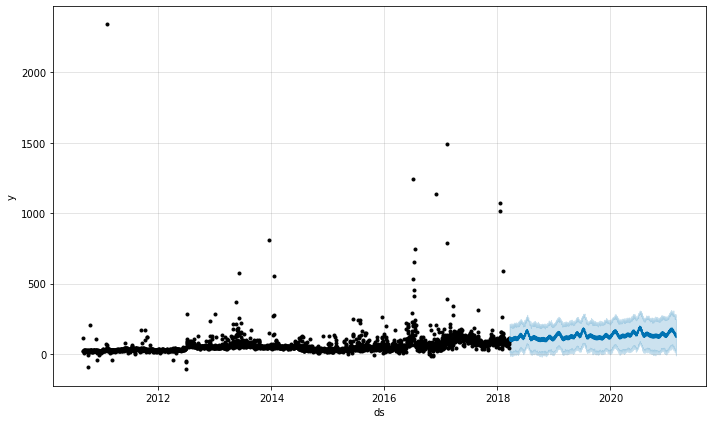

In [21]:
# Make prediction
forecast_univariate = model_univariate.predict(future_univariate)

# Visualize the forecast
model_univariate.plot(forecast_univariate);

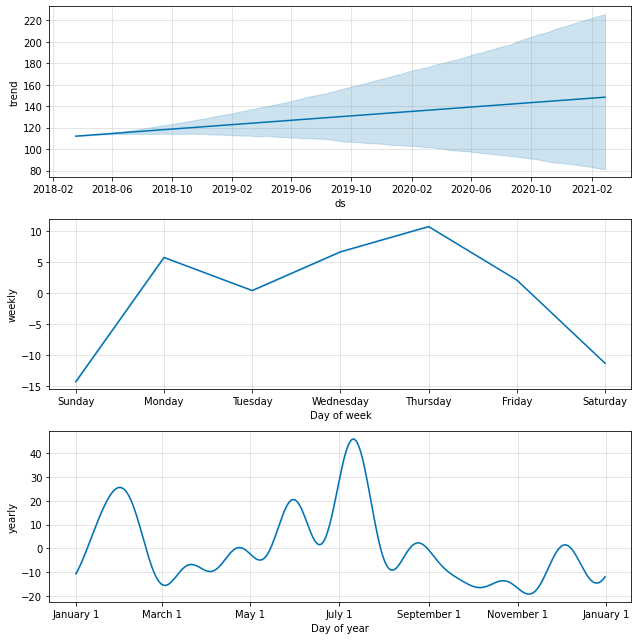

In [22]:
# Visualize the forecast components
model_univariate.plot_components(forecast_univariate);

In [23]:
forecast_univariate.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,112.06,10.29,201.21,112.06,112.06,-6.46,-6.46,-6.46,0.41,0.41,0.41,-6.86,-6.86,-6.86,0.00,0.00,0.00,105.61
1,2018-03-21,112.10,8.54,213.55,112.10,112.10,-0.10,-0.10,-0.10,6.64,6.64,6.64,-6.74,-6.74,-6.74,0.00,0.00,0.00,111.99
2,2018-03-22,112.13,18.98,211.16,112.13,112.13,3.99,3.99,3.99,10.71,10.71,10.71,-6.72,-6.72,-6.72,0.00,0.00,0.00,116.12
3,2018-03-23,112.16,13.66,202.83,112.16,112.16,-4.70,-4.70,-4.70,2.09,2.09,2.09,-6.80,-6.80,-6.80,0.00,0.00,0.00,107.46
4,2018-03-24,112.20,-7.52,190.98,112.20,112.20,-18.27,-18.27,-18.27,-11.31,-11.31,-11.31,-6.96,-6.96,-6.96,0.00,0.00,0.00,93.93


clips the forecasts so that no value is negative (electricity price can't have a negative price!)

In [24]:
forecast_univariate.loc[:,'yhat'] = forecast_univariate['yhat'].clip(lower=0)

In [25]:
forecast_univariate.loc[:,'yhat_lower'] = forecast_univariate.yhat_lower.clip(lower=0)

In [26]:
forecast_univariate[['ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper']].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,105.61,10.29,201.21,112.06,112.06,112.06
1,2018-03-21,111.99,8.54,213.55,112.10,112.10,112.10
2,2018-03-22,116.12,18.98,211.16,112.13,112.13,112.13
3,2018-03-23,107.46,13.66,202.83,112.16,112.16,112.16
4,2018-03-24,93.93,0.00,190.98,112.20,112.20,112.20


In [27]:
y_true = test['y'].values
y_pred = forecast_univariate['yhat'].values

In [28]:
#Calculate the mean absolute error

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 72.656


In [29]:
#Calculate the mean absolute percentage error

mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print('MAPE: %.2f' % mape)

MAPE: 548.24


In [30]:
#Calculate the mean squared error

mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)

MSE: 17947.825


In [31]:
#Calculate the Root mean squared error
import math

rmse = math.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 133.97


In [32]:
print("The MAE for the Univariate model :", mae)
print("The MAPE for the Univariate model :", mape)
print("The RMSE for the Univariate model :", rmse)

The MAE for the Univariate model : 72.65632034332356
The MAPE for the Univariate model : 548.2447535166735
The RMSE for the Univariate model : 133.96949234497666


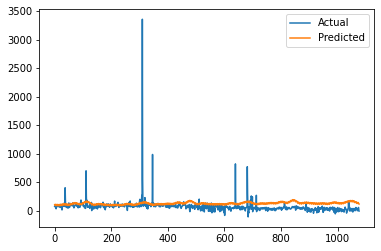

In [33]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

## Multivariate Time series model.

In [34]:
train.columns

Index(['ds', 'tmax', 'sysload', 'gasprice', 'y'], dtype='object')

In [35]:
#model building df_daily

model_multivariate = Prophet()
model_multivariate.add_regressor('tmax')
model_multivariate.add_regressor('sysload')
model_multivariate.add_regressor('gasprice')
model_multivariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/1kffi1uu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/b9yagj67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53269', 'data', 'file=/tmp/tmpr6qgeliq/1kffi1uu.json', 'init=/tmp/tmpr6qgeliq/b9yagj67.json', 'output', 'file=/tmp/tmpr6qgeliq/prophet_modelmr58xbmh/prophet_model-20230122145641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
#make test data as the future into a dataframe

future_multivariate = pd.DataFrame(test[['ds','tmax','sysload','gasprice']])

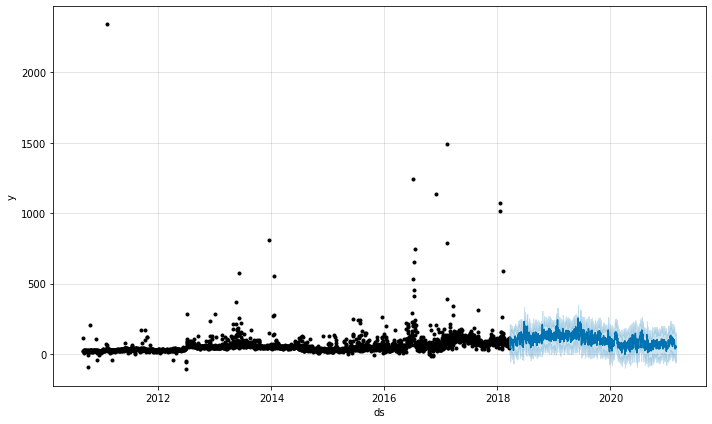

In [37]:
# Create the time range for the forecast
# future_univariate = model_univariate.make_future_dataframe(test['ds'])

# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate);

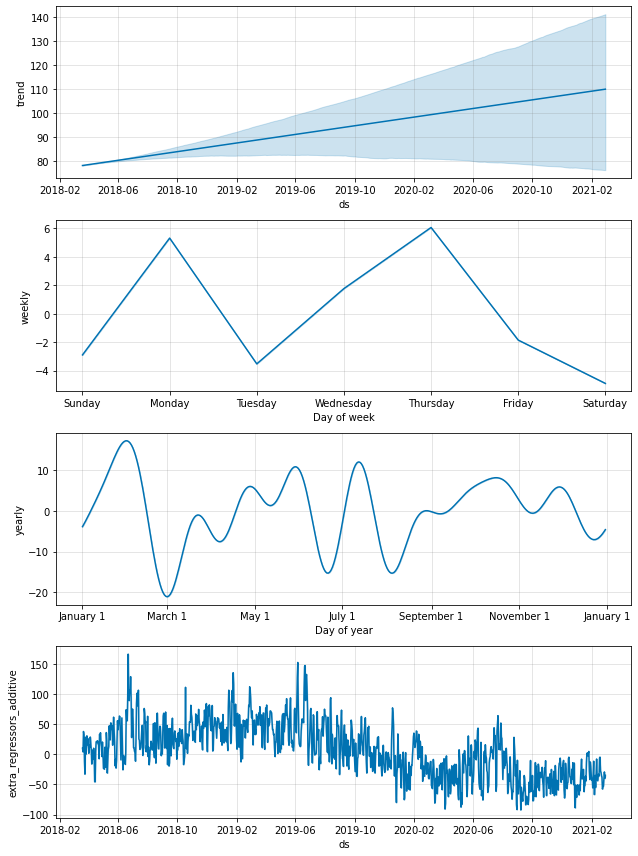

In [38]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [39]:
forecast_multivariate.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,gasprice,gasprice_lower,gasprice_upper,sysload,sysload_lower,sysload_upper,tmax,tmax_lower,tmax_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,78.14,-4.73,175.37,78.14,78.14,4.91,4.91,4.91,10.07,10.07,10.07,45.78,45.78,45.78,-35.72,-35.72,-35.72,0.01,0.01,0.01,-3.52,-3.52,-3.52,-1.63,-1.63,-1.63,0.00,0.00,0.00,83.05
1,2018-03-21,78.17,-5.26,177.79,78.17,78.17,4.52,4.52,4.52,4.00,4.00,4.00,46.79,46.79,46.79,-42.81,-42.81,-42.81,0.01,0.01,0.01,1.77,1.77,1.77,-1.25,-1.25,-1.25,0.00,0.00,0.00,82.69
2,2018-03-22,78.20,23.02,214.17,78.20,78.20,42.87,42.87,42.87,37.84,37.84,37.84,46.79,46.79,46.79,-8.97,-8.97,-8.97,0.01,0.01,0.01,6.06,6.06,6.06,-1.03,-1.03,-1.03,0.00,0.00,0.00,121.07
3,2018-03-23,78.23,13.91,210.20,78.23,78.23,29.68,29.68,29.68,32.53,32.53,32.53,43.98,43.98,43.98,-11.47,-11.47,-11.47,0.01,0.01,0.01,-1.85,-1.85,-1.85,-0.99,-0.99,-0.99,0.00,0.00,0.00,107.91
4,2018-03-24,78.26,-29.55,150.56,78.26,78.26,-18.15,-18.15,-18.15,-12.14,-12.14,-12.14,32.74,32.74,32.74,-44.89,-44.89,-44.89,0.01,0.01,0.01,-4.89,-4.89,-4.89,-1.12,-1.12,-1.12,0.00,0.00,0.00,60.11


clips the forecasts so that no value is negative (electricity price can't have a negative price!)

In [40]:
forecast_multivariate.loc[:,'yhat'] = forecast_multivariate['yhat'].clip(lower=0)

In [41]:
forecast_multivariate.loc[:,'yhat_lower'] = forecast_multivariate.yhat_lower.clip(lower=0)

In [42]:
forecast_multivariate[['ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper']].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,83.05,0.00,175.37,78.14,78.14,78.14
1,2018-03-21,82.69,0.00,177.79,78.17,78.17,78.17
2,2018-03-22,121.07,23.02,214.17,78.20,78.20,78.20
3,2018-03-23,107.91,13.91,210.20,78.23,78.23,78.23
4,2018-03-24,60.11,0.00,150.56,78.26,78.26,78.26


In [43]:
# performance = pd.merge(test, forecast_univariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-1077:], on='ds')

In [44]:
y_true_multi = test['y'].values
y_pred_multi = forecast_multivariate['yhat'].values

In [45]:
#Calculate the mean absolute error

mae_multi = mean_absolute_error(y_true_multi, y_pred_multi)
print('MAE of multivariate model: %.3f' % mae_multi)

MAE of multivariate model: 41.691


In [46]:
#Calculate the mean absolute percentage error

mape_multi = mean_absolute_percentage_error(y_true_multi, y_pred_multi) * 100
print('MAPE of multivariate model: %.2f' % mape_multi)

MAPE of multivariate model: 235.94


In [47]:
#Calculate the mean squared error

mse_multi = mean_squared_error(y_true_multi, y_pred_multi)
print('MSE: %.3f' % mse_multi)

MSE: 12769.714


In [48]:
#Calculate the Root mean squared error
import math

rmse_multi = math.sqrt(mse_multi)
print('RMSE: %.3f' % rmse_multi)

RMSE: 113.003


In [49]:
print("The MAE for the Multivariate model :", mae_multi)
print("The MAPE for the Multivariate model :", mape_multi)
print("The RMSE for the Multivariate model :", rmse_multi)

The MAE for the Multivariate model : 41.69120453919763
The MAPE for the Multivariate model : 235.93834251690328
The RMSE for the Multivariate model : 113.00316145097925


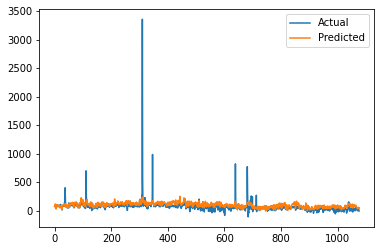

In [50]:
# plot expected vs actual
plt.plot(y_true_multi, label='Actual')
plt.plot(y_pred_multi, label='Predicted')
plt.legend()
plt.show()

## Multivariate model building df_daily without Tmax

In [51]:
#model building df_daily without Tmax

model_multi = Prophet()
# model_multivariate.add_regressor('tmax')
model_multi.add_regressor('sysload')
model_multi.add_regressor('gasprice')
model_multi.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/wopmwmey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr6qgeliq/l9k98ckm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66963', 'data', 'file=/tmp/tmpr6qgeliq/wopmwmey.json', 'init=/tmp/tmpr6qgeliq/l9k98ckm.json', 'output', 'file=/tmp/tmpr6qgeliq/prophet_model_1p794o0/prophet_model-20230122145648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [52]:
#make test data as the future into a dataframe without Tmax

future_multi = pd.DataFrame(test[['ds','sysload','gasprice']])

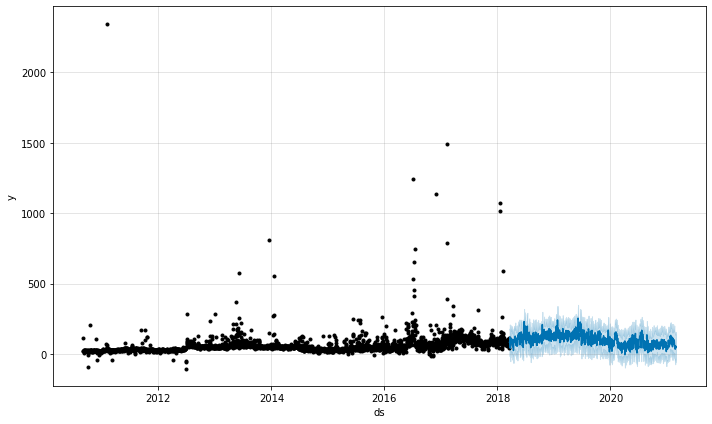

In [53]:
# Create the time range for the forecast
# future_univariate = model_univariate.make_future_dataframe(test['ds'])

# Make prediction
forecast_multi = model_multi.predict(future_multi)

# Visualize the forecast
model_multi.plot(forecast_multi);

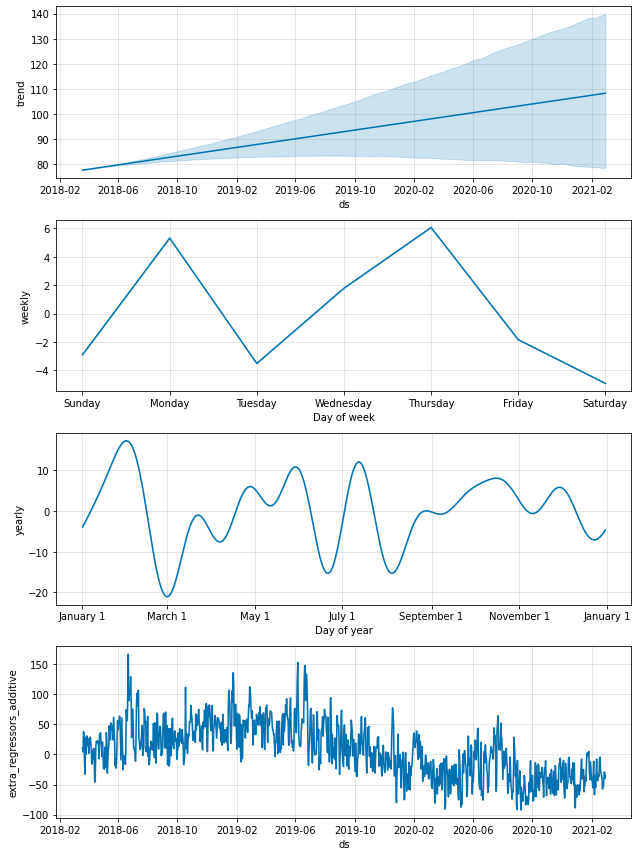

In [54]:
# Visualize the forecast components
model_multi.plot_components(forecast_multi);

In [55]:
forecast_multi.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,gasprice,gasprice_lower,gasprice_upper,sysload,sysload_lower,sysload_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,77.71,-14.75,180.05,77.71,77.71,5.03,5.03,5.03,10.15,10.15,10.15,45.80,45.80,45.80,-35.65,-35.65,-35.65,-3.51,-3.51,-3.51,-1.61,-1.61,-1.61,0.00,0.00,0.00,82.74
1,2018-03-21,77.74,-11.54,171.75,77.74,77.74,4.65,4.65,4.65,4.10,4.10,4.10,46.82,46.82,46.82,-42.72,-42.72,-42.72,1.78,1.78,1.78,-1.23,-1.23,-1.23,0.00,0.00,0.00,82.39
2,2018-03-22,77.77,26.98,209.46,77.77,77.77,42.91,42.91,42.91,37.87,37.87,37.87,46.82,46.82,46.82,-8.95,-8.95,-8.95,6.06,6.06,6.06,-1.02,-1.02,-1.02,0.00,0.00,0.00,120.67
3,2018-03-23,77.80,19.59,199.12,77.80,77.80,29.75,29.75,29.75,32.56,32.56,32.56,44.00,44.00,44.00,-11.44,-11.44,-11.44,-1.83,-1.83,-1.83,-0.98,-0.98,-0.98,0.00,0.00,0.00,107.54
4,2018-03-24,77.82,-32.80,153.03,77.82,77.82,-18.07,-18.07,-18.07,-12.04,-12.04,-12.04,32.76,32.76,32.76,-44.80,-44.80,-44.80,-4.91,-4.91,-4.91,-1.11,-1.11,-1.11,0.00,0.00,0.00,59.76


clips the forecasts so that no value is negative (electricity price can't have a negative price!)

In [56]:
forecast_multi.loc[:,'yhat'] = forecast_multi['yhat'].clip(lower=0)

In [57]:
forecast_multi.loc[:,'yhat_lower'] = forecast_multi.yhat_lower.clip(lower=0)

In [58]:
forecast_multi[['ds' , 'yhat' , 'yhat_lower' , 'yhat_upper' , 'trend' , 'trend_lower' , 'trend_upper']].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2018-03-20,82.74,0.00,180.05,77.71,77.71,77.71
1,2018-03-21,82.39,0.00,171.75,77.74,77.74,77.74
2,2018-03-22,120.67,26.98,209.46,77.77,77.77,77.77
3,2018-03-23,107.54,19.59,199.12,77.80,77.80,77.80
4,2018-03-24,59.76,0.00,153.03,77.82,77.82,77.82


In [59]:
y_true_m = test['y'].values
y_pred_m = forecast_multi['yhat'].values

In [60]:
#Calculate the mean absolute percentage error of multivariate model without Tmax

mape_m = mean_absolute_percentage_error(y_true_m, y_pred_m) * 100
print('MAPE of multivariate model: %.2f' % mape_m)

MAPE of multivariate model: 230.78


In [61]:
# ADF of sysload

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_daily[ 'sysload' ])
print( f'ADF Statistic: {adf_result[ 0 ]} ' )
print( f'p-value: {adf_result[ 1 ]} ' )
print( f'No. of lags used: {adf_result[ 2 ]} ' )
print( f'No. of observations used : {adf_result[ 3 ]} ' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f' {k} : {v} ' ) 

ADF Statistic: -3.6901589888366413 
p-value: 0.0042537255045741835 
No. of lags used: 30 
No. of observations used : 3803 
Critical Values:
 1% : -3.432070672988693 
 5% : -2.8623002987378547 
 10% : -2.567174716967499 


In [62]:
# ADF of gasprice

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_daily[ 'gasprice' ])
print( f'ADF Statistic: {adf_result[ 0 ]} ' )
print( f'p-value: {adf_result[ 1 ]} ' )
print( f'No. of lags used: {adf_result[ 2 ]} ' )
print( f'No. of observations used : {adf_result[ 3 ]} ' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f' {k} : {v} ' ) 

ADF Statistic: -2.902766697165181 
p-value: 0.045027212884625294 
No. of lags used: 27 
No. of observations used : 3806 
Critical Values:
 1% : -3.4320693157877544 
 5% : -2.8622996992165364 
 10% : -2.5671743978048323 


In [63]:
# ADF of elecprice (y)

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_daily[ 'y' ])
print( f'ADF Statistic: {adf_result[ 0 ]} ' )
print( f'p-value: {adf_result[ 1 ]} ' )
print( f'No. of lags used: {adf_result[ 2 ]} ' )
print( f'No. of observations used : {adf_result[ 3 ]} ' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f' {k} : {v} ' ) 

ADF Statistic: -8.269053866873804 
p-value: 4.848817773711633e-13 
No. of lags used: 20 
No. of observations used : 3813 
Critical Values:
 1% : -3.432066157296446 
 5% : -2.8622983040036005 
 10% : -2.5671736550459663 
